<a href="https://colab.research.google.com/github/piratevector/Mesa_NeuralAgents/blob/main/Mesa_ABM_NeuralAgent_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install mesa
import numpy as np
import mesa
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 4.3 MB/s eta 0:00:00


# Introduction

This simulation is an implementation of an agent-based model (ABM) using the Mesa framework, enhanced with artificial neural network (ANN) decision-making, inspired by the Sugarscape model described in the paper, "Using Neural Networks for a Universal Framework for Agent-based Models"<sup>1</sup>.

<br>

**Overview of the Simulation:**

* Environment:
  The agents inhabit a 2D grid (21x21) with periodic (toroidal) boundary conditions. The center of the grid has the highest concentration of a resource ("sugar"), which decreases radially outward.

* Agents:
  Each agent is initialized at a random location and has a wealth variable initially set to zero. They move on the grid in search of sugar, aiming to maximize their wealth.

* Agent Decision Making (Neural Network):
  Agents use sensory input from their immediate environment (sugar amounts and agent occupancy in adjacent cells) to decide their next move.Decision-making is modeled through a trained Multi-layer Perceptron (MLP) classifier, which learns from agents' experiences during a training phase.

<br>

> <small>1. Jäger, G. (2021). *Using Neural Networks for a Universal Framework for Agent-based Models*. Mathematical and Computer Modelling of Dynamical Systems, 27(1), 162–178. [https://doi.org/10.1080/13873954.2021.1889609](https://doi.org/10.1080/13873954.2021.1889609)</small>


## Functions and Methods:

    NeuralAgent.step():

  * Determines the best action using neural network predictions based on sensory input.

  * Executes the selected action.


    NeuralSugarscape.get_agent_input(agent):

  * Gathers sensory inputs (sugar levels and agent occupancy) from adjacent grid cells for an agent.


    NeuralSugarscape.perform_action(agent, action):

  * Moves the agent and updates its wealth based on sugar collected at the new position.


In [3]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


class NeuralAgent(mesa.Agent):
    def __init__(self, model):
        super().__init__(model)
        self.wealth = 0

    def step(self):
        input_features = self.model.get_agent_input(self)
        actions = ["STAY", "NORTH", "SOUTH", "EAST", "WEST"]

        best_action, best_confidence = None, -np.inf
        for action in actions:
            feature_vector = np.append(input_features, actions.index(action))
            feature_tensor = torch.tensor(feature_vector, dtype=torch.float32)
            output = self.model.nn(feature_tensor)
            confidence = output[1].item() - output[0].item()
            if confidence > best_confidence:
                best_confidence = confidence
                best_action = action

        self.model.perform_action(self, best_action)


class NeuralSugarscape(mesa.Model):
    def __init__(self, width=21, height=21, num_agents=75, training_steps=5000):
        super().__init__()
        self.grid = mesa.space.MultiGrid(width, height, torus=True)
        self.num_agents = num_agents
        self.sugar = np.array([[15 - np.sqrt((x - 10)**2 + (y - 10)**2) for x in range(width)] for y in range(height)])

        # Create agents
        for _ in range(num_agents):
            agent = NeuralAgent(self)
            x, y = self.random.randrange(width), self.random.randrange(height)
            self.grid.place_agent(agent, (x, y))

        # Gather experience (random actions)
        data_X, data_y = [], []
        for _ in range(training_steps):
            for agent in self.agents:
                input_features = self.get_agent_input(agent)
                action = self.random.choice([0, 1, 2, 3, 4])
                initial_wealth = agent.wealth
                self.perform_action(agent, ["STAY", "NORTH", "SOUTH", "EAST", "WEST"][action])
                result = np.sign(agent.wealth - initial_wealth)
                data_X.append(np.append(input_features, action))
                data_y.append(result + 1)  # Adjust labels to [0, 1, 2]

        # Convert data to tensors
        X_tensor = torch.tensor(np.array(data_X), dtype=torch.float32)
        y_tensor = torch.tensor(np.array(data_y), dtype=torch.long)

        # Define neural network
        self.nn = NeuralNet(input_size=X_tensor.shape[1], hidden_size=20, output_size=3)

        # Train neural network
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.nn.parameters(), lr=0.01)

        for epoch in range(100):
            optimizer.zero_grad()
            outputs = self.nn(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            optimizer.step()

    def get_agent_input(self, agent):
        x, y = agent.pos
        sugar = [self.sugar[(y - 1) % self.grid.height, x], self.sugar[(y + 1) % self.grid.height, x],
                 self.sugar[y, (x - 1) % self.grid.width], self.sugar[y, (x + 1) % self.grid.width], self.sugar[y, x]]
        agent_counts = [len(self.grid.get_cell_list_contents([(x, (y - 1) % self.grid.height)])),
                        len(self.grid.get_cell_list_contents([(x, (y + 1) % self.grid.height)])),
                        len(self.grid.get_cell_list_contents([((x - 1) % self.grid.width, y)])),
                        len(self.grid.get_cell_list_contents([((x + 1) % self.grid.width, y)])),
                        len(self.grid.get_cell_list_contents([(x, y)]))]
        return np.array(sugar + agent_counts)

    def perform_action(self, agent, action):
        move_dict = {"STAY": (0, 0), "NORTH": (0, -1), "SOUTH": (0, 1), "EAST": (1, 0), "WEST": (-1, 0)}
        dx, dy = move_dict[action]
        new_pos = ((agent.pos[0] + dx) % self.grid.width, (agent.pos[1] + dy) % self.grid.height)
        agent.wealth += self.sugar[new_pos[1], new_pos[0]]
        self.grid.move_agent(agent, new_pos)

    def step(self):
        self.agents.shuffle_do("step")


**Phases of the Simulation:**

1. Initialization. Grid is created with sugar values assigned via: $s(x,y)=15−(x−10)^2+(y−10)^2$

  This creates a gradient of sugar values peaking at the center.

2. Experience Gathering (Training Phase)

    Agents initially take random actions (move North, South, East, West, or Stay) for several steps (5000 in this implementation).

    After each action, the resulting change in the agent's wealth (collected sugar) is recorded as:

        Positive (1) if wealth increases,

        Negative (-1) if wealth decreases,

        Neutral (0) if no change.

    These experiences form a dataset (data_X, data_y) to train the neural network, with inputs including both sensory inputs and the chosen actions.

3. Neural Network Training

    A Multi-Layer Perceptron (MLP) classifier is trained using collected experience data.

    Input features for training:

    - Sugar amounts in adjacent cells (North, South, East, West, Current position)

    - Number of agents present in these cells

    - Chosen action (encoded numerically)

    - Output labels for training:

        - Change in wealth (positive, negative, neutral).

4. Application Phase (Neural Network Decision-Making)

    After training, agents use the neural network to choose actions:

    - For each possible action, the network predicts whether the outcome will be positive, neutral, or negative.

    - Agents select the action with the highest predicted positive confidence.

In [5]:
# Run model
model = NeuralSugarscape()
for i in range(1000):
    model.step()

# Output results
agent_positions = [agent.pos for agent in model.agents]
agent_wealth = [agent.wealth for agent in model.agents]

<Axes: >

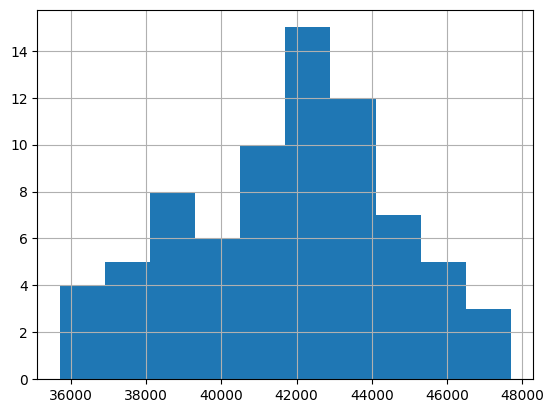

In [6]:
pd.Series(agent_wealth).hist()

## Results:

After running for 1000 simulation steps post-training, we have access to:

        Final positions of all agents on the grid.

        Final wealth distribution, indicating how much sugar each agent collected.

**Practical Uses of This Simulation:**

* Demonstrating how machine learning can automate rule formation for agent behaviors.

* Investigating collective outcomes and emergent behaviors without predefined decision rules.

* Exploring spatial distribution, resource gathering, and competition dynamics among autonomous decision-makers.